In [2]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 1. Preprocess the Data

This part we give the formula and the head 5 lines of the data

In [3]:
dat = pd.read_csv('feds.csv')
dat.Date = pd.to_datetime(dat.Date)

In [4]:
dat['year'] =  pd.DatetimeIndex(dat.Date).year
dat['month'] =  pd.DatetimeIndex(dat.Date).month


In [5]:
dat_month = dat.groupby(['year','month']).first().reset_index()
year = dat_month.pop('year')
month = dat_month.pop('month')
# dat_month['year'] = year
# dat_month['month'] = month
dat_month = dat_month.set_index('Date')
dat_month = dat_month[1:]
dat_month.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,
1961-07-31,2.7780,3.2304,3.5068,3.6787,3.7907,3.8678,3.9234,NaN,NaN,NaN
1961-08-31,2.9863,3.3990,3.6481,3.7919,3.8812,3.9412,3.9841,NaN,NaN,NaN
1961-09-29,2.9358,3.3250,3.5412,3.6661,3.7442,3.7968,3.8345,NaN,NaN,NaN
1961-10-31,2.8936,3.2396,3.4616,3.6087,3.7096,3.7813,3.8339,NaN,NaN,NaN
1961-11-30,3.0000,3.3013,3.5216,3.6775,3.7825,3.8477,3.8817,NaN,NaN,NaN


In [6]:
bond_price = dat_month / 100

bond_price['spot'] = np.ones(len(bond_price)) 
cols = bond_price.columns.tolist()
bond_price = bond_price[[cols[-1]] + cols[:-1]] 

bond_price.head()


,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.027780,0.032304,0.035068,0.036787,0.037907,0.038678,0.039234,NaN,NaN,NaN
1961-08-31,1.0,0.029863,0.033990,0.036481,0.037919,0.038812,0.039412,0.039841,NaN,NaN,NaN
1961-09-29,1.0,0.029358,0.033250,0.035412,0.036661,0.037442,0.037968,0.038345,NaN,NaN,NaN
1961-10-31,1.0,0.028936,0.032396,0.034616,0.036087,0.037096,0.037813,0.038339,NaN,NaN,NaN
1961-11-30,1.0,0.030000,0.033013,0.035216,0.036775,0.037825,0.038477,0.038817,NaN,NaN,NaN


In [7]:
for i in range(11):
    bond_price.iloc[:, i] = np.exp(-bond_price.iloc[:, i] * i)
bond_price.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.972602,0.937435,0.900141,0.863166,0.827344,0.792892,0.759847,NaN,NaN,NaN
1961-08-31,1.0,0.970578,0.934279,0.896333,0.859267,0.823608,0.789408,0.756625,NaN,NaN,NaN
1961-09-29,1.0,0.971069,0.935663,0.899212,0.863601,0.829270,0.796277,0.764590,NaN,NaN,NaN
1961-10-31,1.0,0.971479,0.937262,0.901362,0.865586,0.830705,0.797018,0.764623,NaN,NaN,NaN
1961-11-30,1.0,0.970446,0.936107,0.899741,0.863208,0.827683,0.793849,0.762068,NaN,NaN,NaN


$$p_t^{(n)} = ln(bondPrice)$$

In [8]:
p = np.log(bond_price)
p.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,0.0,-0.027780,-0.064608,-0.105204,-0.147148,-0.189535,-0.232068,-0.274638,NaN,NaN,NaN
1961-08-31,0.0,-0.029863,-0.067980,-0.109443,-0.151676,-0.194060,-0.236472,-0.278887,NaN,NaN,NaN
1961-09-29,0.0,-0.029358,-0.066500,-0.106236,-0.146644,-0.187210,-0.227808,-0.268415,NaN,NaN,NaN
1961-10-31,0.0,-0.028936,-0.064792,-0.103848,-0.144348,-0.185480,-0.226878,-0.268373,NaN,NaN,NaN
1961-11-30,0.0,-0.030000,-0.066026,-0.105648,-0.147100,-0.189125,-0.230862,-0.271719,NaN,NaN,NaN


$$ y_t{(n)} = -\frac1n p_t^{(n)}$$

In [54]:
y = p.copy()
for i in range(1,11):
    y.iloc[:,i] = -1.0/(i) * y.iloc[:,i]
y.spot = np.ones(len(y))

y.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.027780,0.032304,0.035068,0.036787,0.037907,0.038678,0.039234,NaN,NaN,NaN
1961-08-31,1.0,0.029863,0.033990,0.036481,0.037919,0.038812,0.039412,0.039841,NaN,NaN,NaN
1961-09-29,1.0,0.029358,0.033250,0.035412,0.036661,0.037442,0.037968,0.038345,NaN,NaN,NaN
1961-10-31,1.0,0.028936,0.032396,0.034616,0.036087,0.037096,0.037813,0.038339,NaN,NaN,NaN
1961-11-30,1.0,0.030000,0.033013,0.035216,0.036775,0.037825,0.038477,0.038817,NaN,NaN,NaN


$$f_t^{(n)} = p_t^{(n-1)} - p_t^{(n)}$$

In [55]:
f = p.copy()
f = -f.diff(axis = 1)
f.spot = np.ones(len(f))
f.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.027780,0.036828,0.040596,0.041944,0.042387,0.042533,0.042570,NaN,NaN,NaN
1961-08-31,1.0,0.029863,0.038117,0.041463,0.042233,0.042384,0.042412,0.042415,NaN,NaN,NaN
1961-09-29,1.0,0.029358,0.037142,0.039736,0.040408,0.040566,0.040598,0.040607,NaN,NaN,NaN
1961-10-31,1.0,0.028936,0.035856,0.039056,0.040500,0.041132,0.041398,0.041495,NaN,NaN,NaN
1961-11-30,1.0,0.030000,0.036026,0.039622,0.041452,0.042025,0.041737,0.040857,NaN,NaN,NaN


$$r_{t+1}^{(n)} = p_{t+1}^{(n-1)} - _t^{(n)}$$

In [56]:
p1 = p.copy()
p1 = p1.shift(-12) # t+1
p1 = p1.shift(1, axis=1) # n-1
r = p1 - p
r.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,NaN,0.027780,0.033298,0.037274,0.039802,0.041295,0.042158,0.042654,NaN,NaN,NaN
1961-08-31,NaN,0.029863,0.038200,0.046633,0.051503,0.053608,0.054127,0.053821,NaN,NaN,NaN
1961-09-29,NaN,0.029358,0.037903,0.044746,0.047620,0.047694,0.046203,0.043919,NaN,NaN,NaN
1961-10-31,NaN,0.028936,0.036415,0.041852,0.044868,0.046000,0.045863,0.044927,NaN,NaN,NaN
1961-11-30,NaN,0.030000,0.036376,0.042592,0.047194,0.049909,0.050757,0.049767,NaN,NaN,NaN


$$ rx_{t+1}^{(n)} = r_{t+1}^{(n)} - y_t^{(1)}$$

In [90]:
y1 = y.copy()
for i in range(2,11):
    y1.iloc[:,i] = y1.iloc[:,1]
rx = r - y1

rx.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,NaN,0.0,0.005518,0.009494,0.012022,0.013515,0.014378,0.014874,NaN,NaN,NaN
1961-08-31,NaN,0.0,0.008337,0.016770,0.021640,0.023745,0.024264,0.023958,NaN,NaN,NaN
1961-09-29,NaN,0.0,0.008545,0.015388,0.018262,0.018336,0.016845,0.014561,NaN,NaN,NaN
1961-10-31,NaN,0.0,0.007479,0.012916,0.015932,0.017064,0.016927,0.015991,NaN,NaN,NaN
1961-11-30,NaN,0.0,0.006376,0.012592,0.017194,0.019909,0.020757,0.019767,NaN,NaN,NaN


# 2. The Regression

In [134]:
# Set train and test data
idx_5 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1'))
idx_10 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1972-1-1'))
idx_train5 = (y.index < pd.to_datetime('2008-1-1')) & (y.index > pd.to_datetime('1964-1-1'))
idx_test5 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('2008-1-1'))
idx_train10 = (y.index < pd.to_datetime('2008-1-1')) & (y.index > pd.to_datetime('1972-1-1'))
idx_test10 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('2008-1-1'))

# Select 5 year data
yt5 = y[idx_5].iloc[:,1:6]
ft5 = f[idx_5].iloc[:,1:6]
rxt5 = rx[idx_5].iloc[:,2:6]
rxt_bar5 = rxt5.mean(axis = 1)

# Select 10 year data
yt10 = y[idx_10].iloc[:,1:11]
ft10 = f[idx_10].iloc[:,1:11]
rxt10 = rx[idx_10].iloc[:,2:11]
rxt_bar10 = rxt10.mean(axis = 1)


# Select 5 year train data
yt_train5 = y[idx_train5].iloc[:,1:6]
ft_train5 = f[idx_train5].iloc[:,1:6]
rxt_train5 = rx[idx_train5].iloc[:,2:6]
rxt_bar_train5 = rxt_train5.mean(axis = 1)

# Select 5 year test data
yt_test5 = y[idx_test5].iloc[:,1:6]
ft_test5 = f[idx_test5].iloc[:,1:6]
rxt_test5 = rx[idx_test5].iloc[:,2:6]
rxt_bar_test5 = rxt_test5.mean(axis = 1)

# Select 10 year train data
yt_train10 = y[idx_train10].iloc[:,1:11]
ft_train10 = f[idx_train10].iloc[:,1:11]
rxt_train10 = rx[idx_train10].iloc[:,2:11]
rxt_bar_train10 = rxt_train10.mean(axis = 1)

# Select 10 year test data
yt_test10 = y[idx_test10].iloc[:,1:11]
ft_test10 = f[idx_test10].iloc[:,1:11]
rxt_test10 = rx[idx_test10].iloc[:,2:11]
rxt_bar_test10 = rxt_test10.mean(axis = 1)

## Single factor model regression

# whole period regression(1964-2018)

In [162]:
model = LinearRegression()
R_sq = np.zeros(4)

model.fit(ft5,rxt_bar5)
gamma = model.coef_
R_sq = model.score(ft5,rxt_bar5)


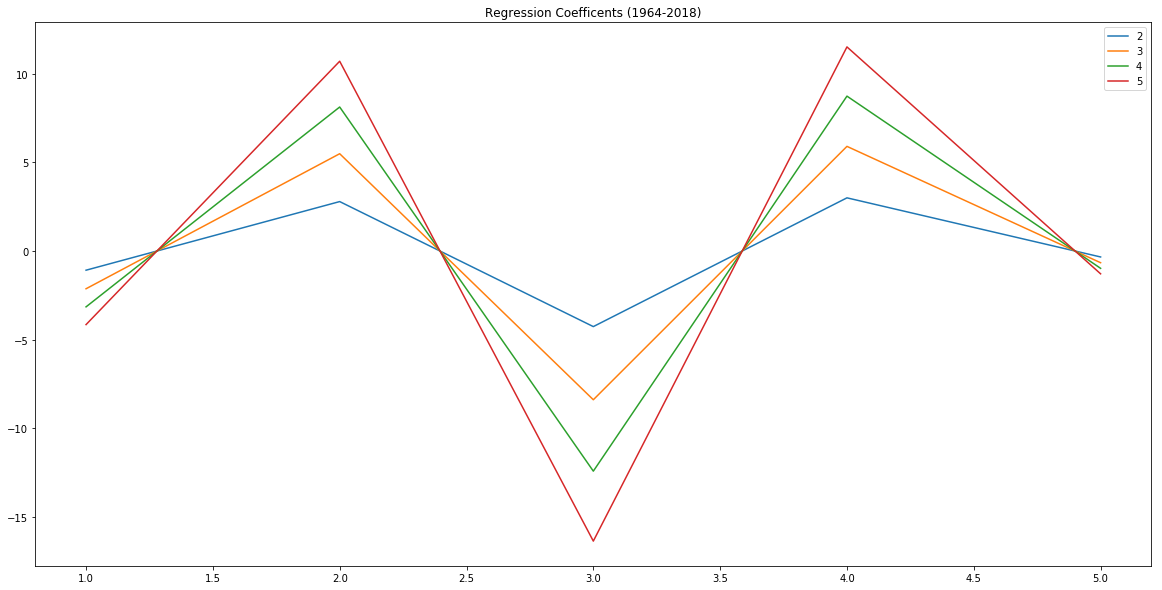

In [163]:
aux = pd.DataFrame(np.sum((ft5).mul(gamma), axis = 1))
aux.insert(0, 'ones', np.ones(len(aux)))

models = []
b = np.zeros(4)
R_sq = np.zeros(4)
rxt_predict = rxt5.copy()

for i in range(4):
    model = LinearRegression()
    model.fit(aux,rxt5.iloc[:,i])
    b[i] = model.coef_[1]
    rxt_predict.iloc[:,i] = model.predict(aux)
    R_sq[i] = model.score(aux,rxt5.iloc[:,i])
    models.append(model)
plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(range(1,6),b[i]*gamma, label = str(i+2))
rxt_predict_bar = np.mean(rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2018)')
plt.show();

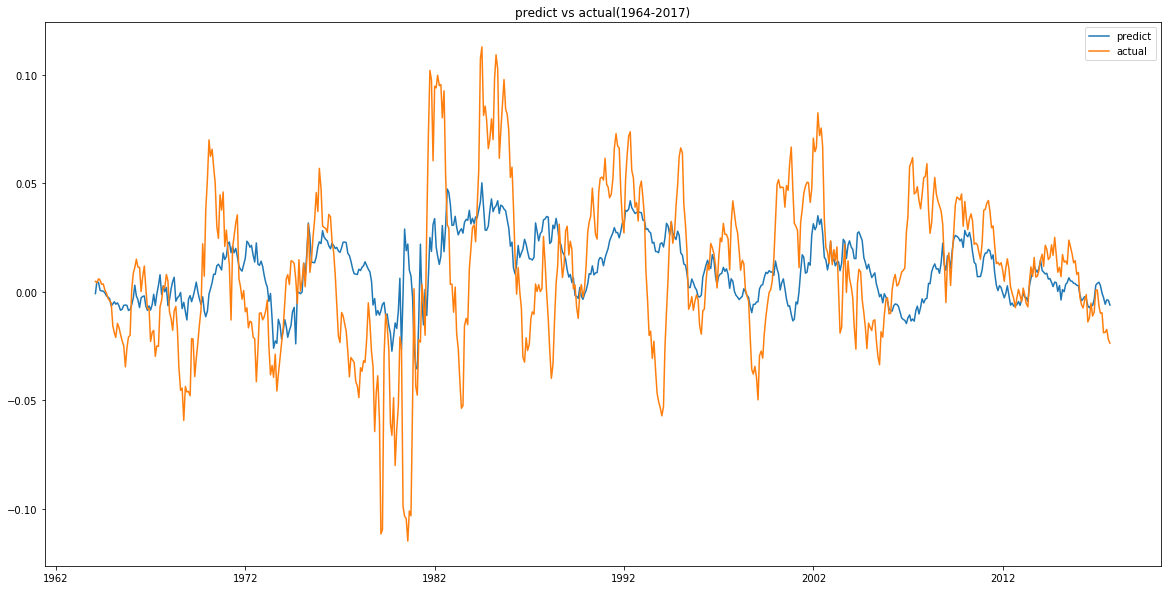

array([ 0.13135938,  0.15414449,  0.17450201,  0.19203684])

In [164]:
plt.figure(figsize=(20,10))
plt.plot(rxt_predict_bar, label='predict')
plt.plot(rxt_bar5, label='actual')
plt.legend()
plt.title('predict vs actual(1964-2017)')
plt.show();
R_sq

# predict data(2008-2018)

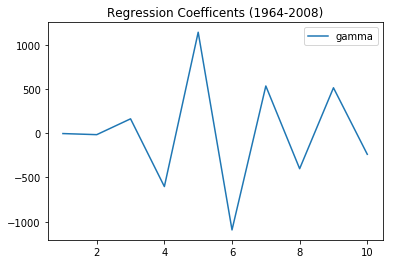

In [172]:
model = LinearRegression()
coef = np.zeros(5)
R_sq = np.zeros(4)

model.fit(ft_train10,rxt_bar_train10)
gamma = model.coef_
R_sq = model.score(ft_train10,rxt_bar_train10)

plt.plot(range(1,11),gamma, label='gamma')
plt.legend()
plt.title('Regression Coefficents (1964-2008)')
plt.show();

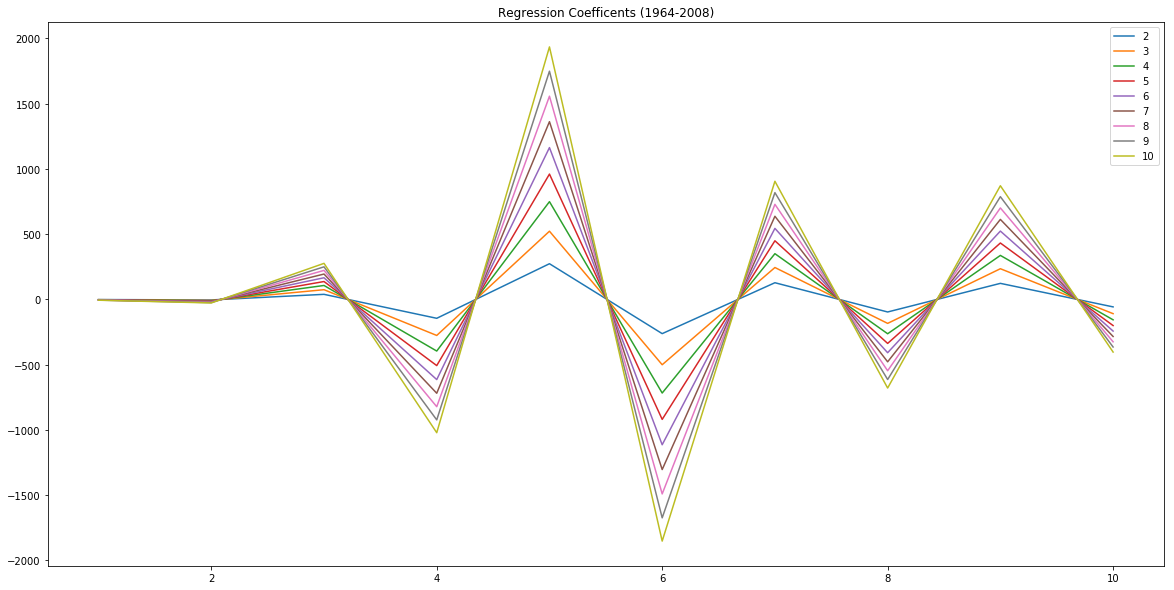

In [175]:
aux = pd.DataFrame(np.sum((ft_train10).mul(gamma), axis = 1))
aux.insert(0, 'ones', np.ones(len(aux)))

models = []
b = np.zeros(9)
R_sq = np.zeros(9)


for i in range(9):
    model = LinearRegression()
    model.fit(aux,rxt_train10.iloc[:,i])
    b[i] = model.coef_[1]
    R_sq[i] = model.score(aux,rxt_train10.iloc[:,i])
    models.append(model)
plt.figure(figsize=(20,10))
for i in range(9):
    plt.plot(range(1,11),b[i]*gamma, label = str(i+2))
plt.legend()
plt.title('Regression Coefficents (1964-2008)')
plt.show();

In [176]:
aux1 = pd.DataFrame(np.sum((ft_test10).mul(gamma), axis = 1))
aux1.insert(0, 'ones', np.ones(len(aux1)))
predicted_rxt = rxt_test10.copy()
r_sq = np.zeros(9)
for i in range(9):
    predicted_rxt.iloc[:,i] = models[i].predict(aux1)
    r_sq[i] = models[i].score(aux1,rxt_test10.iloc[:,i])
predicted_rxt_bar = np.mean(predicted_rxt, axis = 1)
r_sq

array([-0.51888008, -0.79056412, -0.852604  , -0.83518069, -0.81012876,
       -0.79821834, -0.80171899, -0.81771925, -0.84242578])

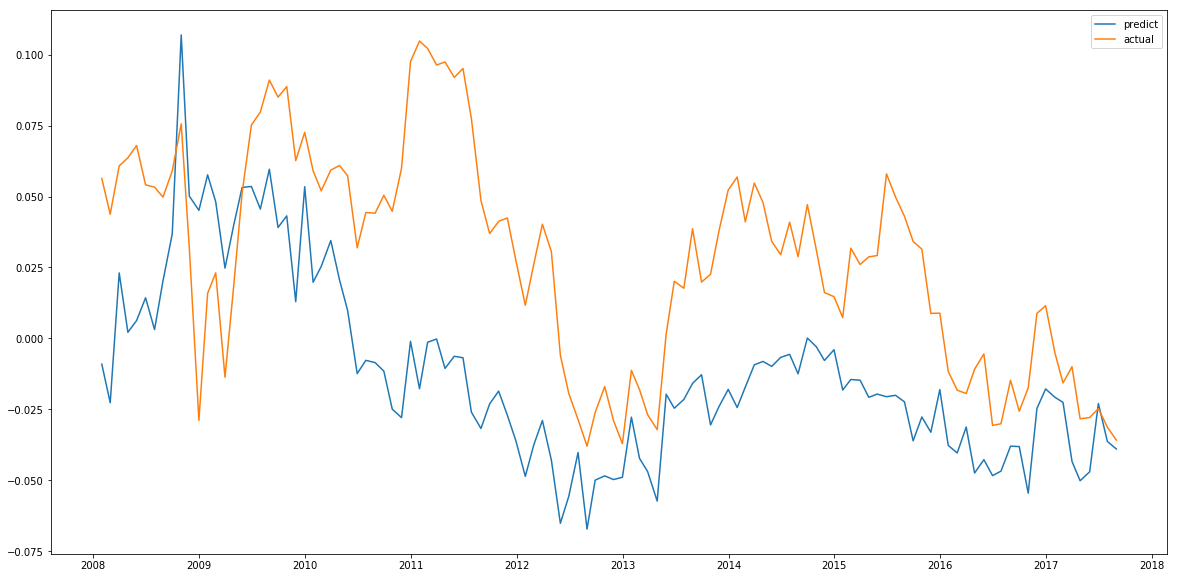

In [177]:
plt.figure(figsize=(20,10))
plt.plot(predicted_rxt_bar, label='predict')
plt.plot(rxt_bar_test10, label='actual')
plt.legend()
plt.show()